In [1]:
import csv
import pathlib
import os
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

IMG_SIZE = 240

In [2]:
DATA_PATH = pathlib.Path("data")


def load_labels(path, file_name):
    with open(path / file_name, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        for annot in reader:
            return 1
    return 0

def load_subset(path, name):
    subset_path = path / name
    images_path = subset_path / 'images'
    labels_path = subset_path / 'labels'
    
    images, labels = [], []

    for file_name in tqdm(os.listdir(images_path)):
        img = Image.open(images_path / file_name)
        img = img.convert("L").resize((IMG_SIZE, IMG_SIZE))
        
        arr = np.asarray(img, dtype=float) / 255.0
        images.append(arr)
        
        file_name = file_name.removesuffix("jpg") + 'txt'
        label = load_labels(labels_path, file_name)
        labels.append(label)
    
    images = np.expand_dims(images, axis=1)
    labels = np.expand_dims(labels, axis=-1)
    return images, labels
        

train_images, train_labels = load_subset(DATA_PATH, 'train')
test_images, test_labels = load_subset(DATA_PATH, 'test')

  0%|          | 0/3672 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

In [3]:
import torch
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)
test_images = torch.tensor(test_images, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import torchmetrics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\piotr\micromamba\envs\pytorch\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\piotr\micromamba\envs\pytorch\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [141]:

class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool_conv = nn.ModuleList([
            nn.Conv2d(1, 3, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(3, 6, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(6, 10, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(10, 16, kernel_size=4, stride=2, padding=1),   
            nn.Conv2d(16, 20, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(20, 24, kernel_size=4, stride=2, padding=1)
        ])
        
        self.conv = nn.Conv2d(24, 24, kernel_size=3, padding=1)
        
        self.l1 = nn.Linear(216, 24)
        self.dropout = nn.Dropout(0.2)
        self.l2 = nn.Linear(24, 1)
        
    def forward(self, x):
        for layer in self.pool_conv:
            x = F.relu(layer(x))
            
        x = F.relu(self.conv(x))
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.l1(x))
        x = F.sigmoid(self.l2(x))
        return x
    

class FaceDetector(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.classifier = CNNClassifier()
        self.valid_acc = torchmetrics.Accuracy(task="binary")
        
    def training_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self.classifier(x)
        
        loss = F.binary_cross_entropy(y_pred, y_true)
        
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self.classifier(x)
        
        loss = F.binary_cross_entropy(y_pred, y_true)
        
        self.valid_acc.update(y_pred, y_true)
        return loss
    
    def on_validation_epoch_end(self):
        self.log("valid_acc", self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [142]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

detector = FaceDetector()
trainer = L.Trainer(max_epochs=30)

train_subset, val_subset = train_test_split(train_dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=3, persistent_workers=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=3, persistent_workers=True)

trainer.fit(model=detector, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | classifier | CNNClassifier  | 27.2 K | train
1 | valid_acc  | BinaryAccuracy | 0      | train
------------------------------------------------------
27.2 K    Trainable params
0         Non-trainable params
27.2 K    Total params
0.109     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\piotr\micromamba\envs\pytorch\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


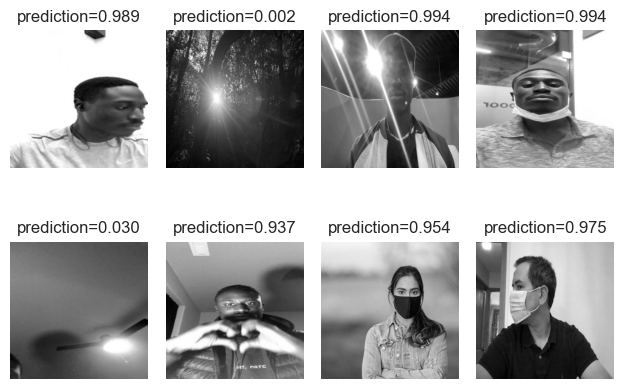

In [147]:
import random
import seaborn as sns
sns.set_theme()

fig, axarr = plt.subplots(2, 4)
for ax in axarr.ravel():
    x = random.choice(test_dataset)[0]
    ax.imshow(x[0], cmap='grey')
    y = float(detector.classifier(x.unsqueeze(0))[0])
    ax.set_title(f"prediction={y:.3f}")
    ax.axis('off')
    
plt.tight_layout()

In [148]:
pred = detector.classifier(test_images)

accuracy = torchmetrics.Accuracy(task='binary')
accuracy(pred, test_labels)

tensor(0.9172)

In [149]:
torch.save(detector.classifier.state_dict(), f"saves/face_detector.pth")

In [150]:
model = CNNClassifier()
model.load_state_dict(torch.load("saves/face_detector.pth", weights_only=True))

<All keys matched successfully>

In [156]:
import torch.onnx
inputs = torch.randn(1, 1, 240, 240)
onnx_program = torch.onnx.export(model, inputs, "saves/face_detector.onnx", 
                                 input_names=['input'], output_names=['output'],
                                 dynamic_axes={'input' : {0 : 'batch_size'},
                                               'output' : {0 : 'batch_size'}},
                                 opset_version=12)

Text(0.5, 1.0, 'prediction=0.994')

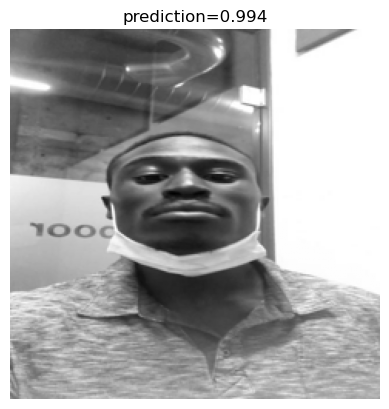

In [11]:

import tensorflow as tf
import random

image, label = random.choice(test_dataset)
fig, ax = plt.subplots(1, 1)
ax.imshow(image[0], cmap='grey')
ax.axis('off')

image = tf.expand_dims(tf.constant(image), axis=0)

model = tf.saved_model.load("saves/face_detector")
res = model.signatures['serving_default'](input=image)['output'].numpy()
ax.set_title(f"prediction={float(res):.3f}")

In [13]:
import tensorflow as tf

def representative_dataset():
    for data in tf.data.Dataset.from_tensor_slices(test_images).batch(1).take(100):
        yield [tf.dtypes.cast(data, tf.float32)]
        
converter = tf.lite.TFLiteConverter.from_saved_model("saves/face_detector")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
                                       tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
                                       tf.lite.OpsSet.SELECT_TF_OPS ]# enable TensorFlow ops.]]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

with open('saves/face_detector.tflite', 'wb') as f:
  f.write(tflite_quant_model)